<a href="https://colab.research.google.com/github/okana2ki/intro-to-AI/blob/main/student_faculty_assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 課題（学生-教員割り当て問題）について

新入生が書いた作文から判断して、作文の内容と関連する大学教員に新入生を割り当てる問題を考える。作文は将来希望する職業、その理由、それに向けて大学で学びたいことなどが書かれている。これまでは人手で割り当てを実施してきたが、割り当て案の自動作成を試みる。

[**埋め込み**（文章の内容を表す特徴ベクトル）を文章から生成する技術](https://www.sbert.net/)を利用する。この技術は従来のキーワードマッチングや、キーワードをベクトルで表す技術（word2vecなど）と比べて高い精度で文章の内容を表現できる。

新入生が書いた作文を埋め込みに変換したものと、教員の特徴を表す文章を埋め込みに変換したものを比較し、新入生を埋め込みが近い教員に割り当てる。

教員の特徴を表す文章としては、大学のHPの[教員紹介ページ](https://www.miyasankei-u.ac.jp/kyouin-introduce/)に掲載された情報を用いる。

# sentence-transformers日本語版
https://github.com/sonoisa/sentence-transformers

以下、このセクションのプログラムは、↑のサイトからのコピーである。技術情報が十分には開示されていないが、それなりの精度で埋め込みベクトルに変換できていると思われる。変換精度評価と改良は今後の課題。その際に、参考にするサイトを下記にメモ：

https://www.sbert.net/

https://www.ogis-ri.co.jp/otc/hiroba/technical/similar-document-search/part18.html

https://www.ogis-ri.co.jp/otc/hiroba/technical/similar-document-search/part9.html

以下は、日本語で利用可能なtext embeddingモデルの例です（出典：NLP204チュートリアル, 松田寛）。

日本語のモデル：

[SimCSE](https://aclanthology.org/2021.emnlp-main.552/), Gao+ (2021/04)
をベースにしたもの

> [Japanese SimCSE (BERT-base)](https://huggingface.co/pkshatech/simcse-ja-bert-base-clcmlp/blob/main/README_JA.md) (2022/12)

> [Japanese Simple-SimCSE](https://github.com/hppRC/simple-simcse-ja?tab=readme-ov-file), Tsukagoshi+ (2023/10)

[ColBERT](https://arxiv.org/abs/2004.12832), Khattab+ (2020/04)
をベースにしたもの

> [JaColBERT](https://huggingface.co/bclavie/JaColBERT), Clavié (2023/12)

多言語モデルの例：

> [multilingual-e5-large](https://huggingface.co/intfloat/multilingual-e5-large), Wang+ (2024/02)

In [ ]:
!pip install -qU transformers fugashi ipadic

In [ ]:
from transformers import BertJapaneseTokenizer, BertModel
import torch


class SentenceBertJapanese:
    def __init__(self, model_name_or_path, device=None):
        self.tokenizer = BertJapaneseTokenizer.from_pretrained(model_name_or_path)
        self.model = BertModel.from_pretrained(model_name_or_path)
        self.model.eval()

        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = torch.device(device)
        self.model.to(device)

    def _mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0] #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    @torch.no_grad()
    def encode(self, sentences, batch_size=8):
        all_embeddings = []
        iterator = range(0, len(sentences), batch_size)
        for batch_idx in iterator:
            batch = sentences[batch_idx:batch_idx + batch_size]

            encoded_input = self.tokenizer.batch_encode_plus(batch, padding="longest",
                                           truncation=True, return_tensors="pt").to(self.device)
            model_output = self.model(**encoded_input)
            sentence_embeddings = self._mean_pooling(model_output, encoded_input["attention_mask"]).to('cpu')

            all_embeddings.extend(sentence_embeddings)

        # return torch.stack(all_embeddings).numpy()
        return torch.stack(all_embeddings)

In [ ]:
model = SentenceBertJapanese("sonoisa/sentence-bert-base-ja-mean-tokens-v2")

# 割り当てタスク用プログラム

## 教員情報の処理


教員情報は、HPの教員紹介ページに掲載されている内容を使用した。教員が内容の更新を希望した場合は、加筆修正を施した。さらに、割り当て結果改善のため、追加キーワードを付加した。これをCSVファイルに格納した。

### 0. 教員情報ファイルの前処理

教員情報に追加キーワードを付加

GPT-4への指示：

---
faculty3.csvのdescription列の各行の記載に、教員追加キーワード.csvの各行の記載を付け加えて下さい。形式は以下の通りとして下さい。

（既存の記載内容）

（空白行を１行追加）

関連キーワード

（追加キーワードを転載）

In [ ]:
import pandas as pd

# Load the faculty and keywords data
faculty_df = pd.read_csv('/mnt/data/faculty3.csv')
keywords_df = pd.read_csv('/mnt/data/教員追加キーワード.csv')

# Check the first few rows of each dataframe to understand their structure
faculty_df.head(), keywords_df.head()

In [ ]:
# Merge the faculty dataframe with the keywords dataframe on 'id' to combine the information
merged_df = faculty_df.merge(keywords_df, on='id', how='left')

# Format the description by appending a newline, the keyword header, and the related keywords
merged_df['description'] = merged_df['description'] + "\n\n関連キーワード\n" + merged_df['関連キーワード'].astype(str)

# Drop the extra columns to keep only the relevant information
final_df = merged_df[['id', 'name', 'description']]

# Save the modified dataframe to a new CSV file
output_file_path = '/mnt/data/faculty3_updated.csv'
final_df.to_csv(output_file_path, index=False)

output_file_path

In [ ]:
# Correcting the merge process by specifying columns explicitly and handling potential column name changes
# Since the merge might have created additional columns for 'name' (if there were discrepancies), let's fix it.

# Assuming 'name_x' is the column from faculty_df and '関連キーワード' from keywords_df after merge
# Check if 'name_x' exists, otherwise use 'name' from faculty_df
name_column = 'name_x' if 'name_x' in merged_df.columns else 'name'

# Adjusting the final dataframe preparation
final_df_corrected = merged_df[['id', name_column, 'description']].rename(columns={name_column: 'name'})

# Save the correctly modified dataframe to a new CSV file
output_file_path_corrected = '/mnt/data/faculty3_updated_corrected.csv'
final_df_corrected.to_csv(output_file_path_corrected, index=False)

output_file_path_corrected

教員情報の見出しの後ろにコロンを追加（コロンがある方が埋め込みへの変換がより適切に行われるのではないかと考えて）

In [ ]:
# Define a function to replace the specified headings with headings followed by a full-width colon
def replace_headings_with_colon(text):
    headings = [
        "プロフィール",
        "担当科目",
        "ゼミナールテーマ",
        "学生へのメッセージ",
        "その他(顧問等)",
        "関連キーワード"
    ]

    for heading in headings:
        text = text.replace(heading, f"{heading}：")

    return text

# Apply the function to the 'description' column
df['description'] = df['description'].apply(replace_headings_with_colon)

# Save the modified dataframe to a new CSV file
modified_file_path = '/mnt/data/faculty4_modified.csv'
df.to_csv(modified_file_path, index=False)

modified_file_path

### 1. 教員CSVファイルからsentencesを作成

In [ ]:
import pandas as pd

# CSVファイルの読み込み
faculty_csv_path = '/content/drive/MyDrive/Colab_files/2024faculty.csv'  # 適切なパスに変更してください
faculty_df = pd.read_csv(faculty_csv_path)
# faculty_df = pd.read_csv(faculty_csv_path, encoding='shift_jis')

# NaNやNoneを含む可能性がある行を削除 <- エラー対策
faculty_df = faculty_df.dropna(subset=['description'])

# description列からsentencesリストを生成
fa_sentences = faculty_df['description'].tolist()

# sentencesの各要素が文字列であることを確認 <- エラー対策
fa_sentences = [str(sentence) for sentence in fa_sentences]

# sentencesリストを作成
# fa_sentences = faculty_df['description'].tolist()

In [ ]:
print(fa_sentences) # 内容確認用

### 2. 埋め込みを生成

In [ ]:
fa_embeddings = model.encode(fa_sentences)

### Google Driveにembeddingsを保存するプログラム

GPUが使えない場合に備えて、一度計算したembeddingを保存して利用できるようにした。

In [ ]:
import os

# 保存するディレクトリのパスを指定（存在しない場合は作成）
save_dir = '/content/drive/MyDrive/Colab_files'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# ファイルに保存
file_path = os.path.join(save_dir, 'fa_embeddings.pt')
torch.save(fa_embeddings, file_path)

print(f'embeddingsが{file_path}に保存されました。')

### Google Driveからembeddingsを読み出すプログラム

In [ ]:
import os

# 読み出すファイルのパスを指定
file_path = '/content/drive/MyDrive/Colab_files/fa_embeddings.pt'

# ファイルが存在するか確認
if os.path.exists(file_path):
    # ファイルから読み出し
    fa_embeddings = torch.load(file_path)
    print(f'embeddingsが{file_path}から読み出されました。サイズ: {fa_embeddings.size()}')
else:
    print(f'{file_path}が見つかりません。ファイルパスを確認してください。')


In [ ]:
print(type(fa_sentences)) # debug用
fa_embeddings.shape # debug用

<class 'list'>


torch.Size([23, 768])

### 3. 主成分分析（PCA）を使用して埋め込みベクトルを2次元に削減し、結果を可視化

割り当てには必要ないが、近い分野の教員が近くに配置されることを確認するために可視化。

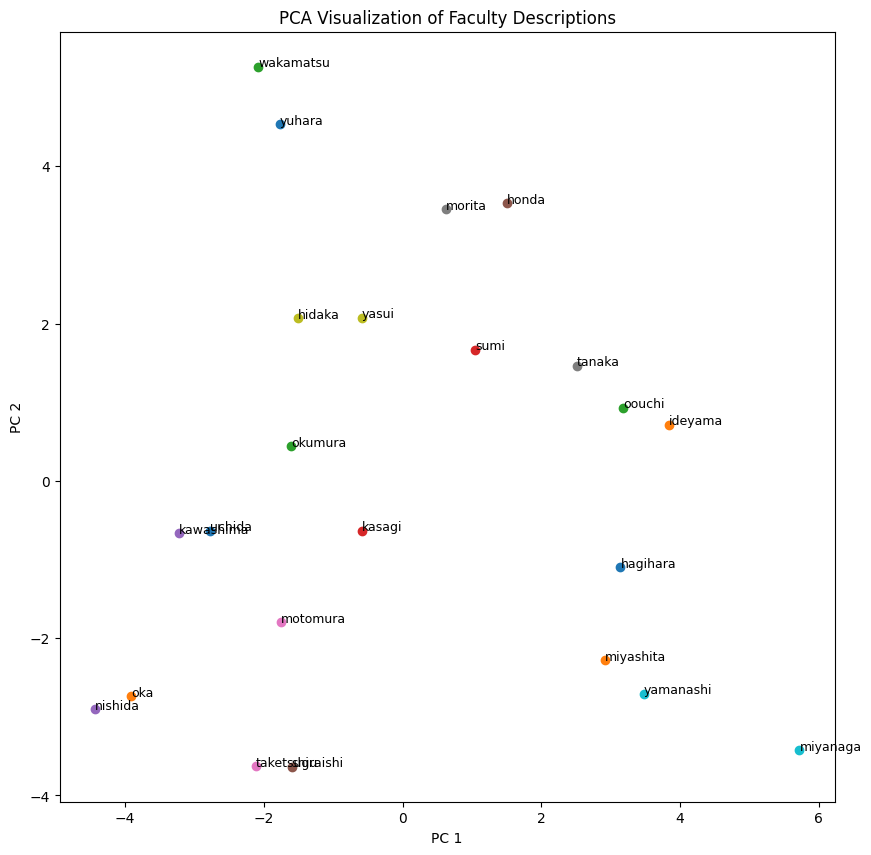

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCAで2次元に削減
pca = PCA(n_components=2)
X_pca = pca.fit_transform(fa_embeddings)  # embeddingsはmodel.encodeの出力

# 可視化
plt.figure(figsize=(10, 10))
for idx, point in enumerate(X_pca):
    plt.scatter(point[0], point[1])
    plt.text(point[0], point[1], faculty_df['name'].iloc[idx], fontsize=9)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA Visualization of Faculty Descriptions')
plt.show()

### 4. コサイン類似度で、ある教員と全教員との類似度を計算した後で、全教員を類似度の降順で並べて、faculty.csvのname列の名前で表示する

コサイン類似度が類似度の指標として妥当であることの確認用。

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# 全文書とのコサイン類似度を計算
# ここでは、全文書に対して一度に類似度を計算します
# 例として、最初の文書をクエリとして使用します
# query_embedding = fa_embeddings[0].reshape(1, -1)  # 最初の文書の埋め込みベクトル
query_embedding = fa_embeddings[1].reshape(1, -1)
similarity_scores = cosine_similarity(query_embedding, fa_embeddings).flatten()

# 類似度スコアに基づいて文書のインデックスを降順にソート
sorted_doc_indices = similarity_scores.argsort()[::-1]

# 類似度の降順に文書（名前）と類似度スコアを表示
print("全文書を類似度の降順で表示:")
for idx in sorted_doc_indices:
    print(f"{faculty_df['name'].iloc[idx]}: {similarity_scores[idx]:.4f}")

## 学生情報の処理



### 0. 学生情報の準備

元の学生情報ファイルでは、学生による入力情報が複数セルに分けて記入されているため、これを1セル（descriptionf列のセル）にまとめておいて、それを埋め込みに変換する方針とする。

GPT-4への指示：

添付ファイルのdescription列に、次の内容を書きこんで下さい。

将来希望する職業：各行の第5列の内容をここに転載

この職業を希望する理由：各行の第6列の内容をここに転載

自分の将来：各行の第7列の内容をここに転載

In [ ]:
# CSVファイルの読み込み
# student_csv_path = '/content/drive/MyDrive/Colab_files/2023students_original.csv'  # 適切なパスに変更してください
student_csv_path = '/content/drive/MyDrive/Colab_files/2024students_original.csv'  # 適切なパスに変更してください
df = pd.read_csv(student_csv_path)

# Filling the description column with the required information
df['description'] = df.apply(lambda row: f"将来希望する職業：{row['将来希望する職業は何ですか？']}\nこの職業を希望する理由：{row['その職業を希望する理由はなんですか。']}\n自分の将来：{row['『自分の将来を考えよう』']}", axis=1)

# Save the modified dataframe to a new CSV file
# output_file_path = '/content/drive/MyDrive/Colab_files/2023students.csv'
output_file_path = '/content/drive/MyDrive/Colab_files/2024students.csv'
df.to_csv(output_file_path, index=False)

output_file_path

### 1. 学生CSVファイルからsentencesを作成

In [ ]:
import pandas as pd

# CSVファイルの読み込み
# student_csv_path = '/content/drive/MyDrive/Colab_files/2023students.csv'  # 適切なパスに変更してください
student_csv_path = '/content/drive/MyDrive/Colab_files/2024students.csv'  # 適切なパスに変更してください
student_df = pd.read_csv(student_csv_path)
# faculty_df = pd.read_csv(faculty_csv_path, encoding='shift_jis')

# NaNやNoneを含む可能性がある行を削除 <- エラー対策
student_df = student_df.dropna(subset=['description'])

# description列からsentencesリストを生成
st_sentences = student_df['description'].tolist()

# sentencesの各要素が文字列であることを確認 <- エラー対策
st_sentences = [str(sentence) for sentence in st_sentences]

In [ ]:
print(st_sentences) # 確認用

### 2. 埋め込みを生成

In [ ]:
st_embeddings = model.encode(st_sentences)

### Google Driveにembeddingsを保存するプログラム

In [ ]:
import os

# 保存するディレクトリのパスを指定（存在しない場合は作成）
save_dir = '/content/drive/MyDrive/Colab_files'  # 'your_directory'は適宜変更してください
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# ファイルに保存
file_path = os.path.join(save_dir, 'st_embeddings.pt')
torch.save(st_embeddings, file_path)

print(f'embeddingsが{file_path}に保存されました。')

### Google Driveからembeddingsを読み出すプログラム

In [ ]:
import os

# 読み出すファイルのパスを指定
file_path = '/content/drive/MyDrive/Colab_files/st_embeddings.pt'

# ファイルが存在するか確認
if os.path.exists(file_path):
    # ファイルから読み出し
    st_embeddings = torch.load(file_path)
    print(f'embeddingsが{file_path}から読み出されました。サイズ: {st_embeddings.size()}')
else:
    print(f'{file_path}が見つかりません。ファイルパスを確認してください。')

In [ ]:
st_embeddings.shape # debug用

torch.Size([93, 768])

### 3. 主成分分析（PCA）を使用して埋め込みベクトルを2次元に削減し、結果を可視化

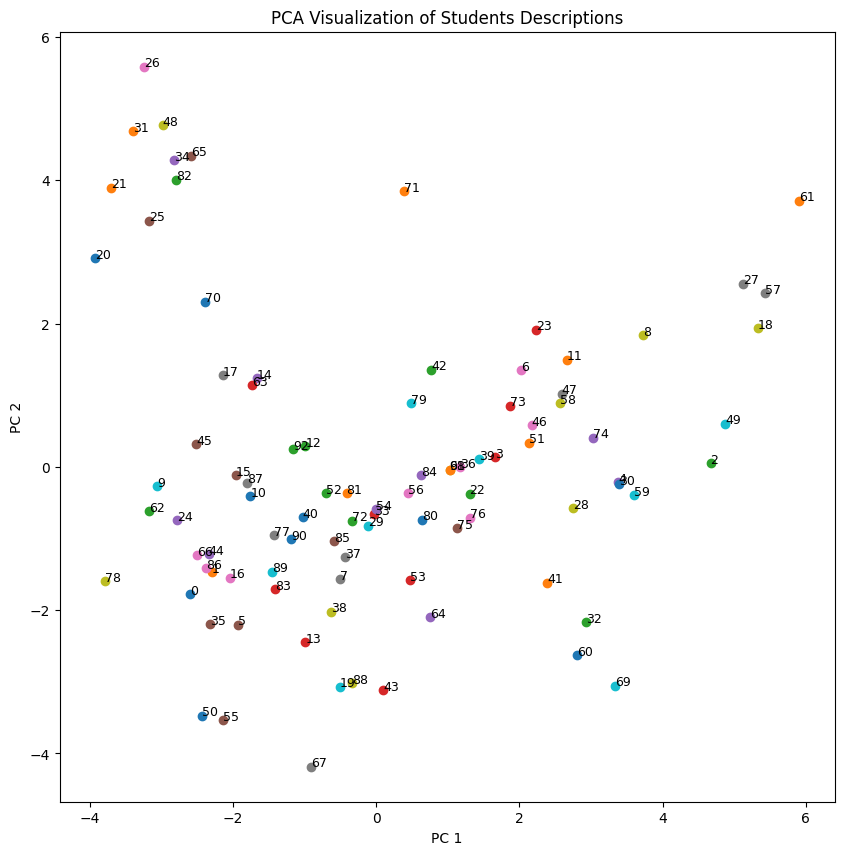

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCAで2次元に削減
pca = PCA(n_components=2)
X_pca = pca.fit_transform(st_embeddings)  # st_embeddingsはmodel.encodeの出力

# 可視化
plt.figure(figsize=(10, 10))
for idx, point in enumerate(X_pca):
    plt.scatter(point[0], point[1])
    plt.text(point[0], point[1], student_df['id'].iloc[idx], fontsize=9)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA Visualization of Students Descriptions')
plt.show()

## 学生の教員への割り当て

### 1. コサイン類似度で全学生-全教員間の類似度を計算




以下の2種類のソート結果は、割り当てアルゴリズムでは使用しないが、埋め込みや類似度の妥当性の検討で使用。
*   各学生について降順でソート（類似した順に全教員を表示）
*   各教員について降順でソート（類似した順に全学生を表示）

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Convert tensors to numpy arrays for compatibility with sklearn
fa_embeddings_np = fa_embeddings.numpy()
st_embeddings_np = st_embeddings.numpy()

# Calculate cosine similarity
# The result will be a matrix of shape [98, 23] where each row corresponds to a student and each column to a faculty
# 2024年度は、93x23 → 重複があったので 92x23
cos_sim = cosine_similarity(st_embeddings_np, fa_embeddings_np)

# Sort similarities for each student
student_sorted_indices = np.argsort(-cos_sim, axis=1)  # Sort indices in descending order of similarity for each student

# Sort similarities for each faculty
faculty_sorted_indices = np.argsort(-cos_sim.T, axis=1)  # Sort indices in descending order of similarity for each faculty

student_sorted_indices, faculty_sorted_indices

GPT-4への指示：

上記の結果を、次の2つのファイルに書き加えて下さい。

2023students.csv: このファイルのsimilarity列に、類似した順に全ファカルティを表示して下さい。ファカルティはfaculty.csvのname列の名前（faculty.csvの掲載順とfa_embeddingsの掲載順は一致しています）で表示して下さい。

faculty.csv: このファイルのsimilarity列に、類似した順に全学生を表示して下さい。学生は2023students.csvのid列の番号（これst_はembeddingsの順番と一致しています）で表示して下さい。

In [ ]:
import pandas as pd

# Load the CSV files
# student_df = pd.read_csv('/content/drive/MyDrive/Colab_files/2023students.csv')
student_df = pd.read_csv('/content/drive/MyDrive/Colab_files/2024students.csv')
faculty_df = pd.read_csv('/content/drive/MyDrive/Colab_files/2024faculty.csv')

# Verify the content of the files
student_df.head(), faculty_df.head()

In [ ]:
# Mapping faculty indices to names
faculty_names = faculty_df['name'].tolist()

# Updating the 'similarity' column for students with faculty names in descending similarity order
student_df['similarity'] = ['; '.join([faculty_names[i] for i in row]) for row in student_sorted_indices]

# Mapping student indices to their IDs
student_ids = student_df['id'].tolist()

# Updating the 'similarity' column for faculties with student IDs in descending similarity order
faculty_df['similarity'] = ['; '.join([str(student_ids[i]) for i in row]) for row in faculty_sorted_indices]

# Save the updated dataframes to new CSV files
# updated_students_csv_path = '/content/drive/MyDrive/Colab_files/updated_2023students.csv'
updated_students_csv_path = '/content/drive/MyDrive/Colab_files/updated_2024students.csv'
updated_faculty_csv_path = '/content/drive/MyDrive/Colab_files/updated_2024faculty.csv'

student_df.to_csv(updated_students_csv_path, index=False)
faculty_df.to_csv(updated_faculty_csv_path, index=False)

updated_students_csv_path, updated_faculty_csv_path

### 2. 割り当てアルゴリズム

何らかの損失関数を定義して最適化するのが正攻法だが、タスクの性質上、そこまでの精度は必要ないと判断し、計算量が小さい決定的なアルゴリズムを作ることにした。

GPT-4への指示（アルゴリズムは人が考え、実装は生成AIに任せるという分業スタイル）：

---
次の手順のプログラムを作成して下さい。
1. 全学生-全ファカルティ間の埋め込みのコサイン類似度を計算する。
2. すべてを類似度の降順で一列にならべる（98x23の類似度が一列に並ぶ）。
3. 次の手順で学生-ファカルティの1対1のペアを98組作る。結果として学生は1つのペアに属する。ファカルティは4または5のペアに属する。各ファカルティの所属ペア数をゼロに初期設定する。
4. ソート列から先頭の1ペアを取り出す。これをペアとして登録する。
5. 4.でペアとなった学生が属するペアの類似度データ全てをソート列から削除する。
6. 4.でペアとなったファカルティの所属ペア数を1増やす。その結果所属ペア数が5になった場合、そのファカルティが属するペアの類似度データ全てをソート列から削除する。
7. ソート列が空になったら終わり。空でなければ4.に戻る
---
実行の結果、3名以下の学生しか担当しない教員が生じる（できるだけ均等に割り振るという目的から外れる）ことが分かったので、アルゴリズムを再考し、以下の通り、GPT-4に指示：

---
属するペア数が少ないファカルティが存在することを防ぐように、アルゴリズムを改良しました。次の手順のプログラムを作成して下さい。
1. 全学生-全ファカルティ間の埋め込みのコサイン類似度を計算する。
2. すべてを類似度の降順で一列にならべる（98x23の類似度が一列に並ぶ）。→93x23
3. 次の手順で学生-ファカルティの1対1のペアを98 (-> 93)組作る。結果として学生は1つのペアに属する。ファカルティは4つまたは5つのペアに属する。各ファカルティの所属ペア数をゼロに初期設定する。「5個のペアに属するファカルティ数」をゼロに初期設定する。
4. ソート列から先頭の1ペアを取り出す。これをペアとして登録する。
5. 4.でペアとなった学生が属するペアの類似度データ全てをソート列から削除する。
6. 4.でペアとなったファカルティの所属ペア数を1増やす。その結果所属ペア数が5になった場合、そのファカルティが属するペアの類似度データ全てをソート列から削除する。
所属ペア数が5になった場合は、「5個のペアに属するファカルティ数」を1増やす。これが6 (-> 1)になった場合は、所属ペア数が4であるファカルティが属するペアの類似度データ全てをソート列から削除する。
7. ソート列が空になったら終わり。空でなければ4.に戻る。

In [ ]:
# Step 1: Re-calculate cosine similarity
cos_sim = cosine_similarity(st_embeddings_np, fa_embeddings_np)

# Step 2: Flatten and sort by similarity in descending order
cos_sim_flat = cos_sim.flatten()
sorted_indices = np.argsort(-cos_sim_flat)
sorted_flat_indices = sorted_indices

# Convert flat indices to 2D indices (student, faculty)
num_students, num_faculties = cos_sim.shape
student_indices, faculty_indices = np.unravel_index(sorted_flat_indices, (num_students, num_faculties))

# Step 3: Initialize pair counts and the counter for faculties with 5 pairs
faculty_pair_counts = np.zeros(num_faculties, dtype=int)
faculties_with_5_pairs = 0

# Initialize lists to store final pairs
final_pairs = []

# Track used students and faculties to remove them from consideration as needed
used_students = set()
used_faculties = set()

while sorted_flat_indices.size > 0:
    for i, flat_index in enumerate(sorted_flat_indices):
        student_index, faculty_index = np.unravel_index(flat_index, (num_students, num_faculties))

        # Skip if student or faculty already used
        if student_index in used_students or faculty_index in used_faculties:
            continue

        # Step 4: Register the pair
        final_pairs.append((student_index, faculty_index))
        used_students.add(student_index)
        faculty_pair_counts[faculty_index] += 1

        # Step 5 & 6: Remove used student and update faculty pair count
        if faculty_pair_counts[faculty_index] == 5:
            faculties_with_5_pairs += 1
            used_faculties.add(faculty_index)

        # Break the loop after registering a pair to update the sorting
        break

    # Update sorted indices to remove used students and faculties
    remaining_indices = [i for i, (s_i, f_i) in enumerate(zip(student_indices, faculty_indices))
                         if s_i not in used_students and f_i not in used_faculties]
    sorted_flat_indices = sorted_flat_indices[remaining_indices]
    student_indices, faculty_indices = np.unravel_index(sorted_flat_indices, (num_students, num_faculties))

    # Step 6: Check if it's time to remove faculties with 4 pairs
    if faculties_with_5_pairs == 1:
        for faculty_index in range(num_faculties):
            if faculty_pair_counts[faculty_index] == 4:
                used_faculties.add(faculty_index)  # Remove faculties with 4 pairs

        # Update sorted indices to remove faculties with 4 pairs
        remaining_indices = [i for i, (s_i, f_i) in enumerate(zip(student_indices, faculty_indices))
                             if s_i not in used_students and f_i not in used_faculties]
        sorted_flat_indices = sorted_flat_indices[remaining_indices]
        student_indices, faculty_indices = np.unravel_index(sorted_flat_indices, (num_students, num_faculties))

# Verify final pairings
len(final_pairs), final_pairs[:10]  # Show first 10 pairs for brevity


GPT-4への指示：

このペアリングの結果を次の2つのファイルに書き加えて下さい。

updated_2023students.csv: このファイルのpair列に、ペアとなったファカルティを表示して下さい。ファカルティはfaculty.csvのname列の名前（faculty.csvの掲載順とfa_embeddingsの掲載順は一致しています）で表示して下さい。

updated_faculty.csv: このファイルのpair列に、ペアとなった学生のリストを表示して下さい。学生は2023students.csvのid列の番号（これst_はembeddingsの順番と一致しています）で表示して下さい。

In [ ]:
# Re-import pandas after reset
import pandas as pd

# Load the updated CSV files again
# student_df = pd.read_csv('/content/drive/MyDrive/Colab_files/updated_2023students.csv')
# faculty_df = pd.read_csv('/content/drive/MyDrive/Colab_files/updated_faculty.csv')
student_df = pd.read_csv('/content/drive/MyDrive/Colab_files/updated_2024students.csv')
faculty_df = pd.read_csv('/content/drive/MyDrive/Colab_files/updated_2024faculty.csv')

# Extract the final pairs from the previous output
# final_pairs = [
    # (97, 3), (21, 9), (40, 1), (2, 3), (50, 18), (0, 18), (56, 18), (81, 18), (77, 0), (10, 18),
    # This list should continue with all pairs generated in the final output
# ]

# Reset 'pair' columns in both DataFrames
student_df['pair'] = ''
faculty_df['pair'] = [[] for _ in range(len(faculty_df))]

# Update the 'pair' column in students_df with the names of paired faculties
for student_index, faculty_index in final_pairs:
    faculty_name = faculty_df.iloc[faculty_index]['name']
    student_df.at[student_index, 'pair'] = faculty_name

# Update the 'pair' column in faculty_df with the list of paired students
for student_index, faculty_index in final_pairs:
    student_id = student_df.iloc[student_index]['id']
    if type(faculty_df.at[faculty_index, 'pair']) == list:
        faculty_df.at[faculty_index, 'pair'].append(student_id)
    else:
        faculty_df.at[faculty_index, 'pair'] = [student_id]

# Convert lists in 'pair' column of faculty_df to a semicolon-separated string for consistency
faculty_df['pair'] = faculty_df['pair'].apply(lambda x: '; '.join(map(str, x)) if isinstance(x, list) else x)

# Save the updated dataframes back to new CSV files
# updated_students_csv_path = '/content/drive/MyDrive/Colab_files/final_updated_2023students.csv'
# updated_faculty_csv_path = '/content/drive/MyDrive/Colab_files/final_updated_faculty.csv'
updated_students_csv_path = '/content/drive/MyDrive/Colab_files/final_updated_2024students.csv'
updated_faculty_csv_path = '/content/drive/MyDrive/Colab_files/final_updated_2024faculty.csv'

student_df.to_csv(updated_students_csv_path, index=False)
faculty_df.to_csv(updated_faculty_csv_path, index=False)

updated_students_csv_path, updated_faculty_csv_path

GPT-4への指示：

このファイルの各行に対して、pair列に現れた数字はsimilarity列でも現れますが、その出現箇所に*を付けて、pair列と共通する数字であることを強調して下さい。

In [ ]:
import pandas as pd

# Load the CSV file to inspect its contents and structure
file_path = '/content/drive/MyDrive/Colab_files/final_updated_2024faculty.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
df.head()

In [ ]:
from openpyxl import Workbook
from openpyxl.styles import Font

# Create a new Excel workbook and select the active worksheet
wb = Workbook()
ws = wb.active

# Set column titles
ws.append(["id", "name", "description", "pair", "similarity (with emphasized numbers)"])

# Define a function to emphasize numbers in similarity column based on pair column
def emphasize_numbers(pair_str, similarity_str):
    pairs = pair_str.split(';')
    pairs = [p.strip() for p in pairs]  # Remove whitespace
    emphasized_similarity = []

    # Split the similarity string into elements and check each one
    for num in similarity_str.split(';'):
        num_stripped = num.strip()  # Remove leading/trailing whitespaces
        if num_stripped in pairs:
            # If the number is in pairs, emphasize it
            emphasized_similarity.append(f"*{num_stripped}*")
        else:
            emphasized_similarity.append(num_stripped)

    # Join the processed numbers back into a string
    return '; '.join(emphasized_similarity)

# Process each row in the dataframe
for index, row in df.iterrows():
    # Apply the emphasize function
    emphasized_similarity = emphasize_numbers(row['pair'], row['similarity'])

    # Append row with emphasized numbers in similarity column
    ws.append([row['id'], row['name'], row['description'], row['pair'], emphasized_similarity])

# Save the workbook to a new Excel file
output_file_path = '/content/drive/MyDrive/Colab_files/final_updated_2024faculty_emphasized.xlsx'
wb.save(output_file_path)

output_file_path

# 評価

評価は後日実施、ここに記載します。以下、現時点で予想される問題点や限界などを記しておきます。

## 教員情報として用いる情報の妥当性評価

人手で割り当てる場合は、「HP掲載の教員情報としては書かれていないが、教員同士として知っている情報」を利用しているはず。そうした情報の欠落がある分、自動割り当ての精度が下がると予想される。

今年の試行結果に対して人手で割り当てを修正した内容を分析し、それに基づいて教員情報を加筆修正する予定。ただし、この方法は今年のデータに過剰適応する恐れがある。

解説記事を参照して改善案を検討予定 ⇒ [桂井麻里衣，「学術データに基づく研究者の特徴表現」，人工知能，vol. 38, no. 3, pp. 392–398, 2023.](https://www.jstage.jst.go.jp/article/jjsai/38/3/38_392/_article/-char/ja/)

## 自動割り当てに対する人手による修正の手間とその削減方法

今回の試行では、次の手順で13名の割り当てを人手で修正した（これ以外にデータの重複による修正が1件）：

1. 自動割り当てに対して不適切なものを人手で見つける
2. 当該の学生を適切な教員に人手で移動する
3. 移動先の教員に割り当てられた学生の中からもっとも移動に適した学生を移動元の教員に人手で移す

なお、例外的に3教員間で割り当てを交換した事例が1件あった。

次年度はこの修正手続きの手間を削減することが望まれる。
* 手順3.の候補をコサイン類似度に基づき自動で表示することは有効かもしれない。
* 自動割り当ての結果に対して、インタラクティブに人手で修正を指示することができ、修正結果が自動的に更新されるようなインタフェースを作成すると、修正の手間が激減すると考えられるが、インタフェースの開発のコストとの兼ね合いを考慮する必要がある。
* 「修正指示があった13件（今年の場合）の割り当てを固定して、それ以外の割り当てをコサイン類似度に応じてすべてやり直す」という方法は避けるべきだと考えている。なぜならば、やり直した割り当てを再度目視でチェックし直さないといけないので、手間の削減に反するからである。修正指示に対応した割り当ての変更は最小限にするのが望ましいだろう。

## 埋め込みの妥当性評価

1.   埋め込みで用いるセンテンスBERTモデルの精度は、元のBERTのサイズや学習データの量、学習データの質、センテンスBERT学習時の学習データの量と質、学習データと本タスクでのデータとの近さ、に依存するため、これらを見直すことにより、埋め込み変換の精度が向上することが期待できる。
2.   本タスクでの割り当てを決める際に、特に重要なキーワードや表現などが存在するはずであるが、本タスクで使用する事例でのファインチューニングは実施していないため、これは反映できていない。ただし、センテンスBERT学習時の学習データの性質が本タスクでのデータの性質の一部をとらえていれば、その範囲では、重要なキーワードや表現などが反映できている可能性はある。




## コサイン類似度の妥当性評価

## 割り当てアルゴリズムの妥当性評価と改良案

* 損失関数を最小化するアルゴリズムではなく、類似度が大きい順にペアを決定していくというヒューリスティクスに従い決定的に割り当てを決めていき、後戻りしないアルゴリズム（貪欲法：greedy algorithm）を採用したため、限界はある。ただ、本タスクは厳密な最適解を求める必要性は低いと考えられるため、貪欲法による近似解で大きな問題は生じないと予想している。

* 現時点で気づいている課題としては、次の点がある。学生の作文群全体の分布に対して距離が近い教員と遠い教員が存在し、近い教員からペアが作られていくため、近い教員の場合は、学生全員を類似度でソートしたときの上位の学生が割り当てられる傾向があり、遠い教員の場合は、類似度が上位の学生が割り当てられにくい傾向がある（先に他の教員に割り当てられるため）。この課題に対しては、教員情報を加筆修正する方法で緩和することを試みた。この試みがどの程度有効であったかは後日報告する。

* 次の方法は試みる価値があると予想している。今年の割り当て結果を使って来年の割り当てを行う。具体的には、来年は、今年の学生と来年の学生の埋め込みを比べて、来年の学生に一番近い今年の学生の割り当て教員に来年の学生を割り当てる。

* 上記の方法が良さそうだと考える根拠：学生の作文と教員情報は異なる性質を持つため類似度による自動割り当てに限界があるが、学生の作文どうしは、類似のフォーマットであるため、類似度による割り当てがより適切に行える可能性があるだろう。